In [54]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from os import cpu_count
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
from pytensor.configdefaults import config
from sklearn.preprocessing import MinMaxScaler
import secrets
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

rng = np.random.default_rng(0)

In [55]:
near_zero = 1e-18

def scale_np(x, min=0., max=1.):
    x_std = (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
    x_scaled = x_std * (max - min) + min
    return x_scaled * (1. - near_zero) + near_zero / 2.

def scale_pt_mat(x, min=0., max=1.):
    x_scaled = pt.transpose(x)
    x_scaled = scale_pt(x_scaled, min, max)
    x_scaled = pt.transpose(x_scaled)
    return x_scaled

def scale_pt(x, min=0., max=1.):
    x_std = (x - pt.min(x, axis=0)) / (pt.max(x, axis=0) - pt.min(x, axis=0))
    x_scaled = x_std * (max - min) + min
    x_transformed = x_scaled * (1. - near_zero) + near_zero / 2.
    return x_transformed

In [56]:
gapminder_series = pd.read_csv("./data/gapminder_quality_of_life_2005_dataset.csv", index_col="country")
gapminder_data = gapminder_series.values
print(gapminder_data[:6, :4])

gapminder_data = scale_np(gapminder_data)
print(gapminder_data[:6, :4])

gapminder_data[:, 1] = 1. - gapminder_data[:, 1]
gapminder_data[:, 2] = 1. - gapminder_data[:, 2]
print(gapminder_data[:6, :4])

X = np.transpose(gapminder_data)
# print(f"X <= 0: {np.where(X <= 0)}")
# print(f"X >= 1: {np.where(X >= 1)}")
# print(f"X shape: {X.shape}")

[[1.35e+03 7.74e+01 7.60e+01 5.76e+01]
 [8.15e+03 1.78e+01 9.00e+00 7.62e+01]
 [1.08e+04 2.90e+01 2.40e+01 7.29e+01]
 [6.13e+04 5.40e+00 9.00e+00 8.14e+01]
 [6.13e+03 1.01e+02 1.19e+02 5.64e+01]
 [2.07e+04 1.06e+01 3.00e+00 7.59e+01]]
[[0.00362483 0.61488673 0.18009479 0.36479592]
 [0.04477485 0.13268608 0.02132701 0.83928571]
 [0.06081126 0.22330097 0.05687204 0.75510204]
 [0.36641069 0.03236246 0.02132701 0.97193878]
 [0.03255088 0.80582524 0.28199052 0.33418367]
 [0.12072085 0.07443366 0.007109   0.83163265]]
[[0.00362483 0.38511327 0.81990521 0.36479592]
 [0.04477485 0.86731392 0.97867299 0.83928571]
 [0.06081126 0.77669903 0.94312796 0.75510204]
 [0.36641069 0.96763754 0.97867299 0.97193878]
 [0.03255088 0.19417476 0.71800948 0.33418367]
 [0.12072085 0.92556634 0.992891   0.83163265]]


In [57]:
num_scores, dims = gapminder_data.shape

alpha_prior = np.repeat([.75], dims) + .25 * (rng.random(dims) - .5)
print(f"alpha_prior <= 0: {np.where(alpha_prior <= 0)}")
print(f"alpha_prior >= 1: {np.where(alpha_prior >= 1)}")
p_1_prior = np.repeat([.3125], dims) + .25 * (rng.random(dims) - .5)
print(f"p_1_prior <= 0: {np.where(p_1_prior <= 0)}")
print(f"p_1_prior >= 1: {np.where(p_1_prior >= 1)}")
p_2_prior = np.repeat([.6875], dims) + .25 * (rng.random(dims) - .5)
print(f"p_2_prior <= 0: {np.where(p_2_prior <= 0)}")
print(f"p_2_prior >= 1: {np.where(p_2_prior >= 1)}")
# s_prior = np.repeat([.5], num_scores) + .25 * (rng.random(num_scores) - .5)
s_prior = np.mean(X, axis=0)
print(f"s_prior <= 0: {np.where(s_prior <= 0)}")
print(f"s_prior >= 1: {np.where(s_prior >= 1)}")
print(f"s_prior shape: {s_prior.shape}")
print(f"s_prior shape: {X.shape}")

alpha_prior <= 0: (array([], dtype=int64),)
alpha_prior >= 1: (array([], dtype=int64),)
p_1_prior <= 0: (array([], dtype=int64),)
p_1_prior >= 1: (array([], dtype=int64),)
p_2_prior <= 0: (array([], dtype=int64),)
p_2_prior >= 1: (array([], dtype=int64),)
s_prior <= 0: (array([], dtype=int64),)
s_prior >= 1: (array([], dtype=int64),)
s_prior shape: (189,)
s_prior shape: (4, 189)


In [58]:
sigma_prior = 1.

with pm.Model() as model:
    sigma = pm.TruncatedNormal(
        name="sigma", 
        mu=sigma_prior, 
        sigma=1., 
        lower=0.
        )
    alpha = pm.TruncatedNormal(
        name="alpha", 
        mu=alpha_prior, 
        sigma=sigma, 
        lower=0.,
        upper=1.
        )
    p_0 = pm.Deterministic(
        name="p_0", var=.5 * (1. - alpha)
        )
    p_1 = pm.TruncatedNormal(
        name="p_1", 
        mu=p_1_prior, 
        sigma=sigma, 
        lower=0.,
        upper=1.
        )
    p_2 = pm.TruncatedNormal(
        name="p_2", 
        mu=p_2_prior, 
        sigma=sigma, 
        lower=0.,
        upper=1.
        )
    p_3 = pm.Deterministic(
        name="p_3", var=.5 * (1. + alpha)
        )
    s = pm.TruncatedNormal(
        name="s", 
        mu=s_prior, 
        sigma=sigma,
        lower=0.,
        upper=1.
        )

    # s_transformed = scale_pt(s)
    s_transformed = s
    # s_transformed_eval = s_transformed.eval()
    # print(f"s_transformed_eval shape: {np.where(s_transformed_eval <= 0)}: {s_transformed_eval[np.where(s_transformed_eval <= 0)]}")

    s_squared = s_transformed ** 2
    # s_squared_eval = s_squared.eval()
    # print(f"s_squared_eval shape: {np.where(s_squared_eval <= 0)}: {s_squared_eval[np.where(s_squared_eval <= 0)]}")

    s_cubed = s_transformed ** 3
    # s_cubed_eval = s_cubed.eval()
    # print(f"s_cubed_eval shape: {np.where(s_cubed_eval <= 0)}: {s_cubed_eval[np.where(s_cubed_eval <= 0)]}")

    Z = pm.math.stack(
        [pt.ones((num_scores,)),
         s_transformed,
         s_squared,
         s_cubed],
         axis=0
    )

    # Z_eval = Z.eval()
    # print(f"Z_eval shape: {np.where(Z_eval <= 0)}: {Z_eval[np.where(Z_eval <= 0)]}")
    # print(f"Z shape: {Z.eval().shape}")

    M = pt.as_tensor(
        [[1, -3,  3, -1], 
         [0,  3, -6,  3],
         [0,  0,  3, -3], 
         [0,  0,  0,  1]]
        )
    # print(f"M shape: {M.eval().shape}")
    
    # P = scale_pt_mat(pm.math.stack([pt.transpose(p_0), pt.transpose(p_1), pt.transpose(p_2), pt.transpose(p_3)], axis=1))
    P = pm.math.stack([pt.transpose(p_0), pt.transpose(p_1), pt.transpose(p_2), pt.transpose(p_3)], axis=1)
    # P_eval = P.eval()
    # print(f"P <= 0: {np.where(P_eval <= 0)}")
    # print(f"P >= 1: {np.where(P_eval >= 1)}")
    # print(f"P shape: {P_eval.shape}")

    X_reconstruction_mu = pm.math.matmul(pm.math.matmul(P, M), Z)
    # X_reconstruction_mu_eval = X_reconstruction_mu.eval()
    # print(f"X_reconstruction_mu <= 0: {np.where(X_reconstruction_mu_eval <= 0)}")
    # print(f"X_reconstruction_mu >= 1: {np.where(X_reconstruction_mu_eval >= 1)}")
    # print(f"X_reconstruction_mu shape: {X_reconstruction_mu_eval.shape}")

    # X_reconstruction_mu_transformed = scale_pt_mat(X_reconstruction_mu)
    # X_reconstruction_mu_transformed_eval = X_reconstruction_mu_transformed.eval()
    # print(f"X_reconstruction_mu_transformed <= 0: {np.where(X_reconstruction_mu_transformed_eval <= 0)}")
    # print(f"X_reconstruction_mu_transformed >= 1: {np.where(X_reconstruction_mu_transformed_eval >= 1)}")
    # print(f"X_reconstruction_mu_transformed shape: {X_reconstruction_mu_transformed_eval.shape}")

    # X_reconstruction = pm.Beta(name="X_reconstruction", mu=X_reconstruction_mu_transformed, sigma=sigma, observed=X)
    # X_reconstruction = pm.Beta(name="X_reconstruction", mu=X_reconstruction_mu_transformed, sigma=sigma_prior, observed=X)

    # X_reconstruction_0 = pm.Beta(name="X_reconstruction_0", mu=X_reconstruction_mu[:, 0], sigma=sigma, observed=X[:, 0])
    # X_reconstruction_1 = pm.Beta(name="X_reconstruction_1", mu=X_reconstruction_mu[:, 1], sigma=sigma, observed=X[:, 1])
    # X_reconstruction_2 = pm.Beta(name="X_reconstruction_2", mu=X_reconstruction_mu[:, 2], sigma=sigma, observed=X[:, 2])
    # X_reconstruction_3 = pm.Beta(name="X_reconstruction_3", mu=X_reconstruction_mu[:, 3], sigma=sigma, observed=X[:, 3])

    X_reconstruction_0 = pm.TruncatedNormal(name="X_reconstruction_0", mu=X_reconstruction_mu[0, :], sigma=sigma, lower=0., upper=1., observed=X[0, :])
    X_reconstruction_1 = pm.TruncatedNormal(name="X_reconstruction_1", mu=X_reconstruction_mu[1, :], sigma=sigma, lower=0., upper=1., observed=X[1, :])
    X_reconstruction_2 = pm.TruncatedNormal(name="X_reconstruction_2", mu=X_reconstruction_mu[2, :], sigma=sigma, lower=0., upper=1., observed=X[2, :])
    X_reconstruction_3 = pm.TruncatedNormal(name="X_reconstruction_3", mu=X_reconstruction_mu[3, :], sigma=sigma, lower=0., upper=1., observed=X[3, :])

    # X_reconstruction = pm.LogitNormal(name="X_reconstruction", mu=X_reconstruction_mu, sigma=sigma_prior, observed=gapminder_data)

    # X_reconstruction = pm.Beta(name="X_reconstruction", mu=X_reconstruction_mu, sigma=sigma_prior, observed=gapminder_data)

    # X_reconstruction = pm.TruncatedNormal(name="X_reconstruction", mu=X_reconstruction_mu, sigma=sigma_prior, lower=0., upper=1., observed=gapminder_data)



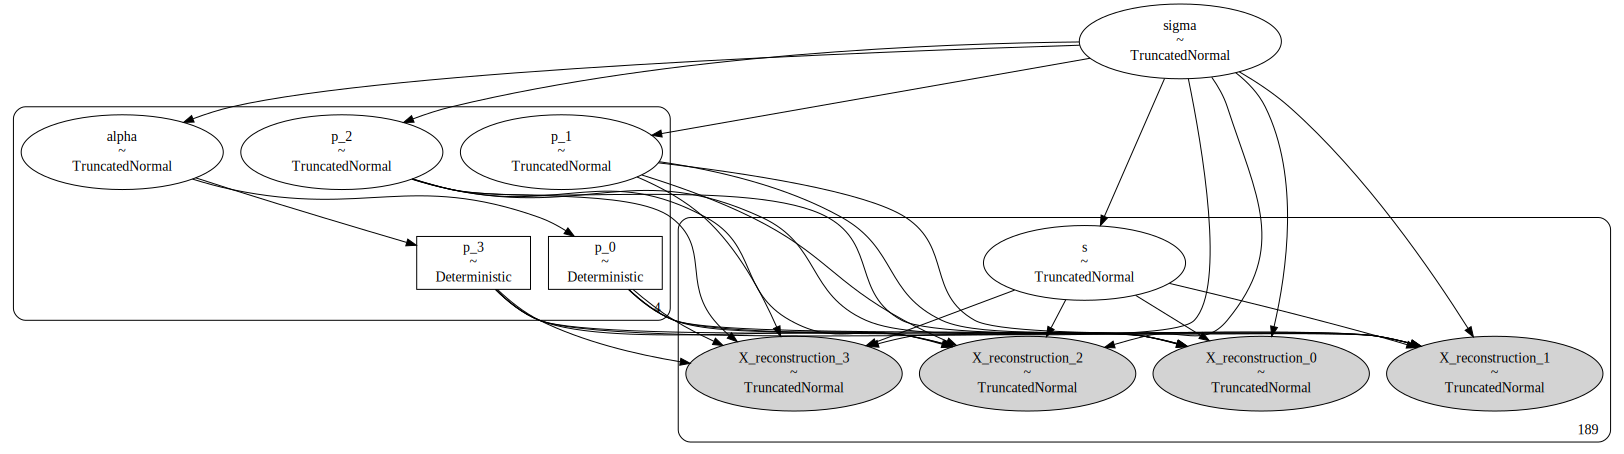

In [59]:
pm.model_to_graphviz(model)

Sampling: [X_reconstruction_0, X_reconstruction_1, X_reconstruction_2, X_reconstruction_3, alpha, p_1, p_2, s, sigma]


array([<Axes: xlabel='X_reconstruction_0'>,
       <Axes: xlabel='X_reconstruction_1'>,
       <Axes: xlabel='X_reconstruction_2'>,
       <Axes: xlabel='X_reconstruction_3'>], dtype=object)

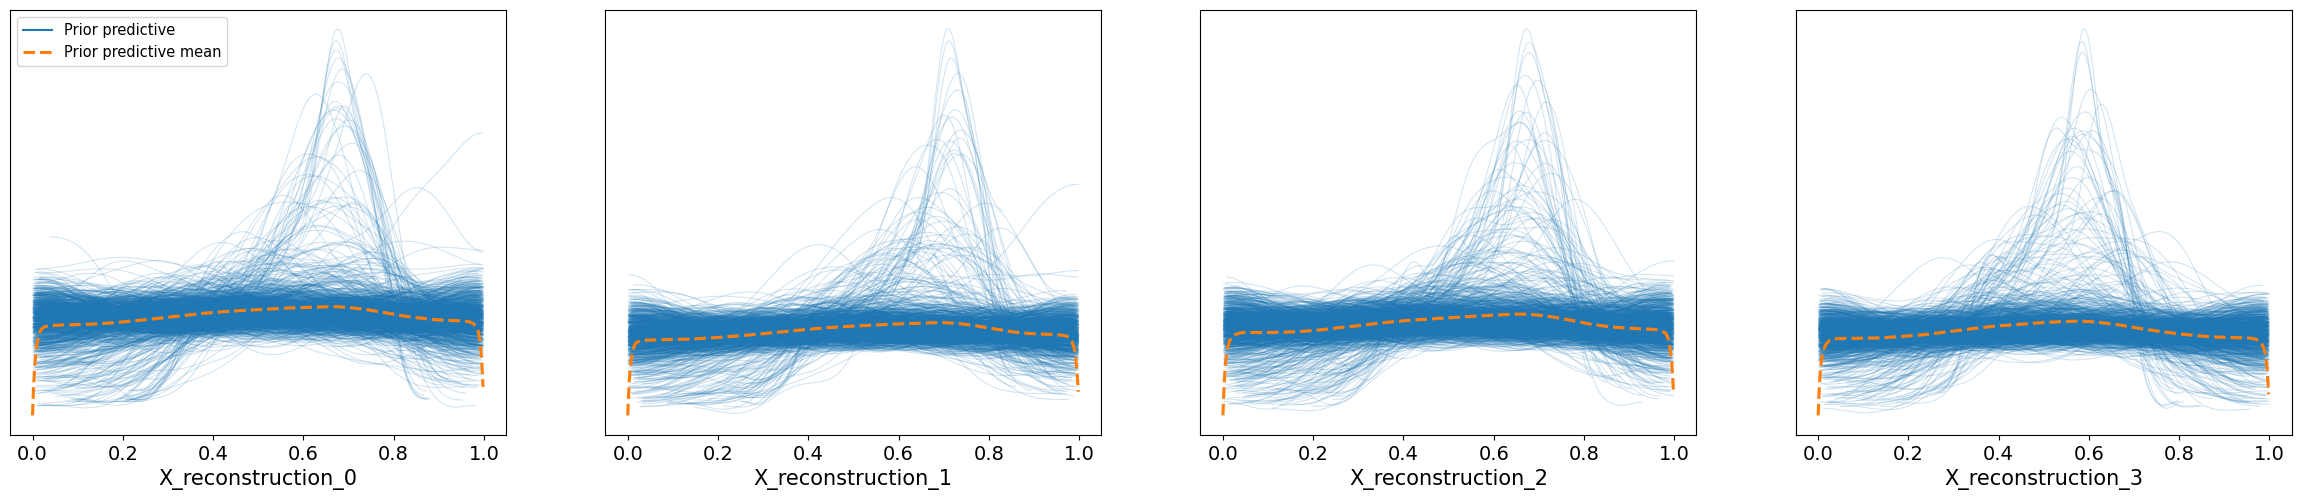

In [60]:
with model:
    predictions = pm.sample_prior_predictive(samples=1000, random_seed=rng)

az.plot_ppc(predictions, group="prior")

In [82]:
# while True:
#     try:
#         seed = secrets.randbits(128)
        
#         rng = np.random.default_rng(seed)
with model:
    initvals = {
        "sigma": sigma_prior,
        "alpha": alpha_prior,
        "p_1": p_1_prior,
        "p_2": p_2_prior,
        "s": s_prior
        }

    with model:
        idata1 = pm.sample(
            nuts_sampler="pymc",
            nuts_sampler_kwargs={"chain_method": "vectorized"},
            target_accept=.99,
            random_seed=rng,
            tune=5000,
            draws=1000,
            chains=4,
            cores=4,
            initvals=initvals
        )
    
    #         print(f"seed: {seed}")

    #         break
    # except pm.SamplingError:
    #     pass

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, p_1, p_2, s]
/home/ubuntu/anaconda3/envs/irt/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/home/ubuntu/anaconda3/envs/irt/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 255 seconds.


In [83]:

with model:
    idata1 = pm.sample_posterior_predictive(
        idata1, extend_inferencedata=True, random_seed=rng)

az.to_netcdf(idata1, "./results/rpc_pymc_2024-05-12_1938.nc")

Sampling: [X_reconstruction_0, X_reconstruction_1, X_reconstruction_2, X_reconstruction_3]


Output()

'./results/rpc_pymc_2024-05-12_1938.nc'

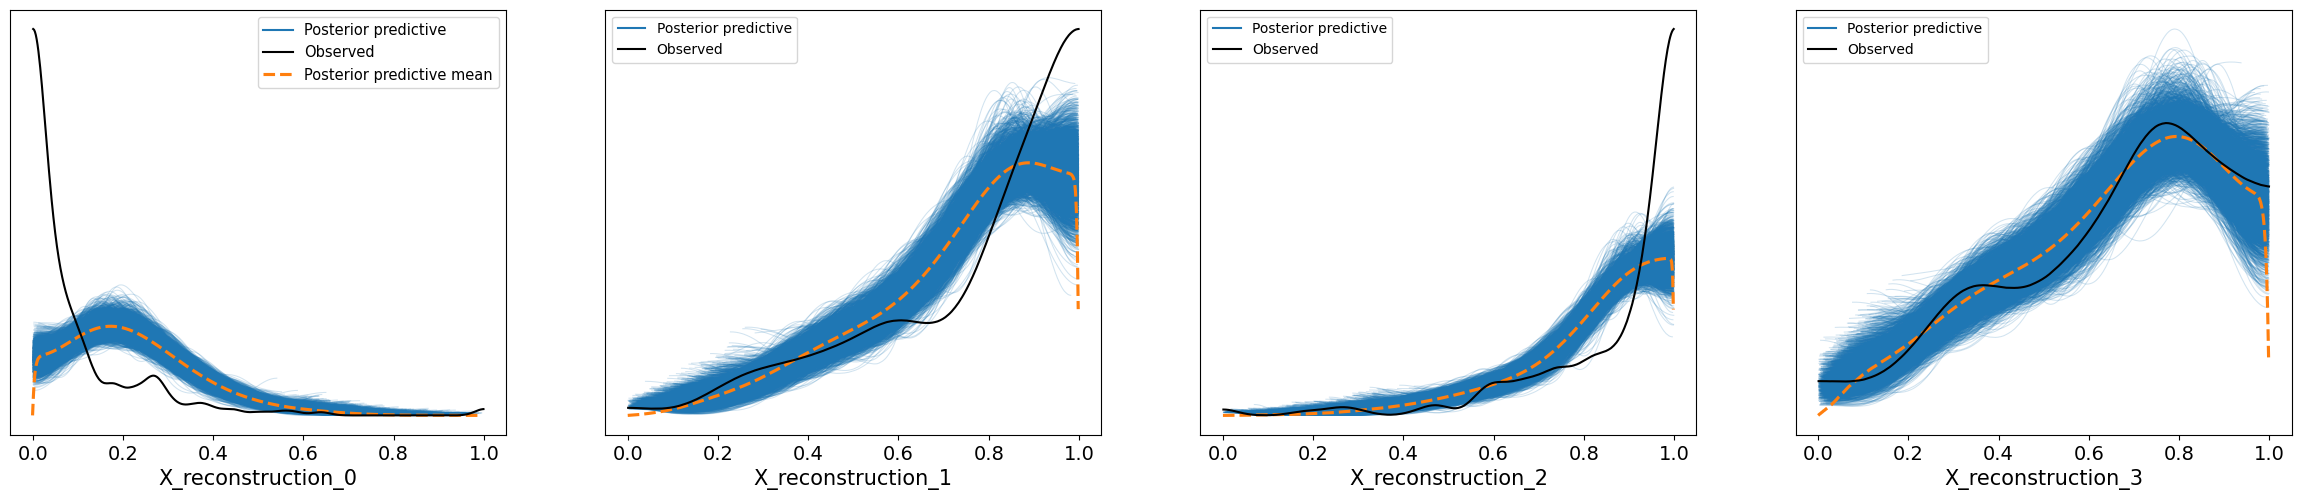

In [84]:
ppc_plot = az.plot_ppc(idata1)
plt.savefig(f'./results/rpc_pymc_2024-05-12_1938_ppc_plot.png')

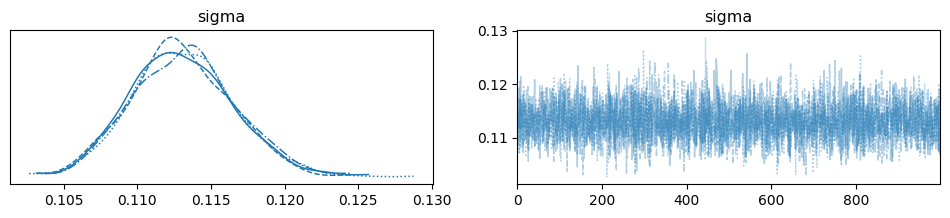

In [85]:
sigma_trace_plot = az.plot_trace(idata1, var_names=['sigma'])
fig = sigma_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_2024-05-12_1938_sigma_trace_plot.png')

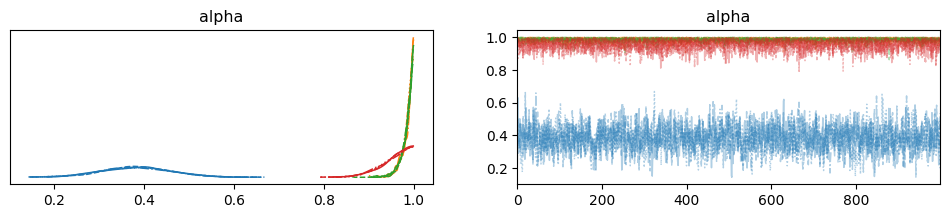

In [86]:
rater_severity_trace_plot = az.plot_trace(idata1, var_names=['alpha'])
fig = rater_severity_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_2024-05-12_1938_alpha_trace_plot.png')

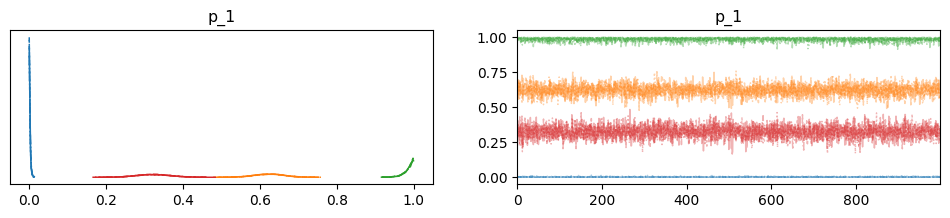

In [87]:
rater_severity_trace_plot = az.plot_trace(idata1, var_names=['p_1'])
fig = rater_severity_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_2024-05-12_1938_p_1_trace_plot.png')

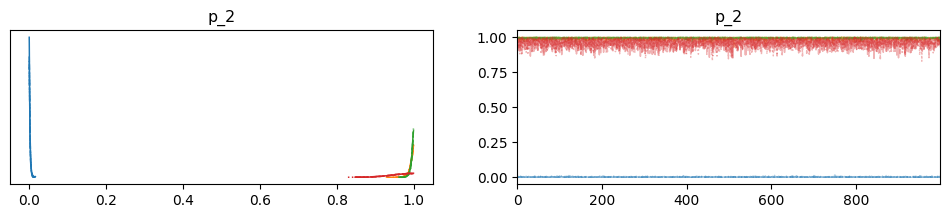

In [88]:
rater_severity_trace_plot = az.plot_trace(idata1, var_names=['p_2'])
fig = rater_severity_trace_plot.flatten()[0].get_figure()
fig.savefig(f'./results/rpc_pymc_2024-05-12_1938_p_2_trace_plot.png')

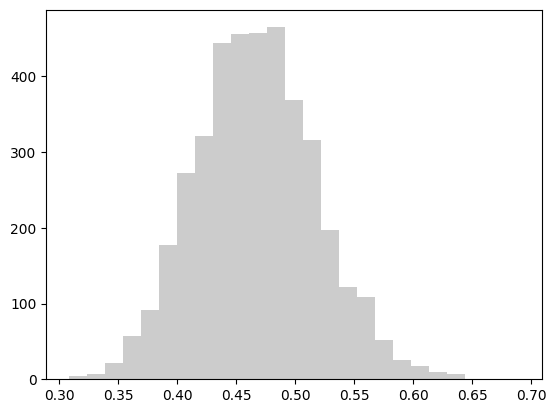

In [89]:
posterior = idata1.posterior.stack(sample=("chain", "draw"))
plt.hist(posterior["s"][186], 25, alpha=0.2, color='k')
plt.savefig(f'./results/rpc_pymc_2024-05-12_1938_s_hist_plot.png')

In [90]:
gapminder_series

,gdp,imr,it,le,score
country,,,,,
Monaco,166000.0,1.4,1,79.0,0.982473
Luxembourg,106000.0,2.8,6,79.5,0.934892
San Marino,83500.0,3.4,3,81.6,0.895342
UAE,96000.0,8.4,7,69.2,0.860309
Qatar,90800.0,9.0,26,72.3,0.859323
...,...,...,...,...,...
South Africa,12300.0,50.1,349,52.1,0.193062
Zimbabwe,1840.0,53.9,311,46.8,0.188641
Lesotho,2040.0,72.3,239,43.9,0.188492


In [91]:
scores = np.mean(posterior["s"], axis=1)
# gapminder_series["score"] = scores
gapminder_series.insert(4, "score", scores)
gapminder_series

ValueError: cannot insert score, already exists

In [ ]:
gapminder_series.sort_values("score", inplace=True, ascending=False)
gapminder_series

,gdp,imr,it,le,score
country,,,,,
Monaco,166000.0,1.4,1,79.0,0.982473
Luxembourg,106000.0,2.8,6,79.5,0.934892
San Marino,83500.0,3.4,3,81.6,0.895342
UAE,96000.0,8.4,7,69.2,0.860309
Qatar,90800.0,9.0,26,72.3,0.859323
...,...,...,...,...,...
South Africa,12300.0,50.1,349,52.1,0.193062
Zimbabwe,1840.0,53.9,311,46.8,0.188641
Lesotho,2040.0,72.3,239,43.9,0.188492


In [ ]:
gapminder_series.to_csv("./data/gapminder_quality_of_life_22_with_scores.csv")